# study the sensitivity of $\theta_p$ vs. $\theta_\mu$ to $m_A$

In [1]:
import sys; sys.path.insert(0, '../../'); sys.path.insert(0, '../mupClassification/');  sys.path.insert(0, '../off_beam_on_beam_5e19/'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from axial_mass_tools import *
import seaborn as sns;sns.set(style="white", color_codes=True ,font_scale=2);
%matplotlib inline

OffBeam_scaling: 1.24224698773 = N(on beam)/N(off beam) before sof. trig.
MC_scaling_DATAcosmic: 0.504451038576 = N(POT on beam)/N(POT MC)
MC_scaling_MCcosmic: 0.136225100235 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/AxialMassPlayground//'

In [32]:
genie_samples = dict()
CC1p0pi = dict()
for mA,name in zip([0.7,0.8,0.9,0.99,1.1,1.2,1.3]
                   ,['0_7','0_8','0_9','0_99','1_1','1_2','1_3']):
    genie_samples['mA=%.2f'%mA] = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/genie_files/argon40_numu_mA_'+name+'.csv')
    CC1p0pi['mA=%.2f'%mA] = genie_samples['mA=%.2f'%mA][genie_samples['mA=%.2f'%mA]['CC1p0pi']==True]
    print 'len(CC1p0pi):',len(CC1p0pi['mA=%.2f'%mA])

len(CC1p0pi): 18827
len(CC1p0pi): 21916
len(CC1p0pi): 22097
len(CC1p0pi): 21916
len(CC1p0pi): 22344
len(CC1p0pi): 22325
len(CC1p0pi): 24732


# distribution of events as a function of $p_p$

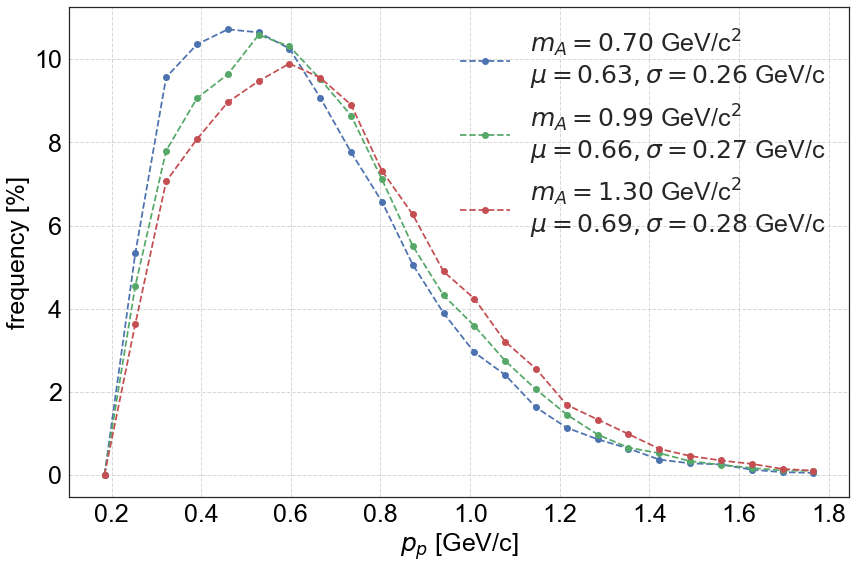

In [33]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
for i_mA,(mA,color) in enumerate(zip([0.7,0.99,1.3] #,0.8,0.9,1.1,1.2
                                     ,['red','blue','green','black','purple','orange','cyan'])):
    sample = CC1p0pi['mA=%.2f'%mA]
    h,bins=np.histogram( sample['Pp'] , bins=np.linspace(0.15,1.8,25));
    t=0.5*(bins[1:]+bins[:-1]); dt=(t[1]-t[0])
    h = 100*h*(1./np.sum(h))
    integral = np.sum([h[j]*dt for j in range(len(h))])
    mean = np.sum([h[j]*t[j]*dt for j in range(len(h))])/integral
    std = np.sqrt( (np.sum([h[j]*t[j]*t[j]*dt for j in range(len(h))])/integral) - np.square(mean) )
    plt.errorbar(t,h,fmt='--o',label=r'$m_A = %.2f$ GeV/c$^2$'%mA+'\n'+r'$\mu=%.2f, \sigma=%.2f$ GeV/c'%(mean,std))
set_axes(ax,r'$p_p$ [GeV/c]','frequency [%]',do_add_grid=True,do_add_legend=True)
plt.tight_layout()    

# lets see how it goes for the two $Q^2$ bins ratio

In [34]:
GENIEall = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/genie/prodgenie_bnb_nu_uboone_overlay_mcc8_reco2_genie.csv')
GENIE_CC1p0pi = GENIEall[GENIEall['IsCC_1p_200MeVc_0pi']==1]
GENIE_CC1p0pi_reconstructed = GENIE_CC1p0pi[GENIE_CC1p0pi['IsVertexReconstructed']==1]

In [38]:
def observable_low_high_ratio(var='Q2',var_name='Q^2',low_high_border=0.4
                              ,do_add_elastic_Xsec=True,do_add_genie_overlay=True
                              ,var_min=0.0,var_max=1.2):

    var_min_bins = np.array([var_min,low_high_border])
    var_max_bins = np.array([low_high_border,var_max])                    
    var_centers = 0.5*(var_min_bins + var_max_bins)

    results = pd.DataFrame(columns=['mA','low-'+var+'/high-'+var+' elastic','low-'+var+'/high-'+var+' genie'])
    mA_array = [0.7,0.9,0.99,1.1,1.2,1.3]
    for i_mA,mA in enumerate(mA_array): # Steve Dytman: GENIE assumes mA=0.99, Dec-30

        sample = CC1p0pi['mA=%.2f'%mA]

        N_inbin,elasticXsec_inbin=[],[]
        for var_min,var_max in zip(var_min_bins,var_max_bins):

            sample_inbin = sample[(sample[var]>var_min)&(sample[var]<var_max)]

            N_inbin.append(float(len(sample_inbin)))

            CCelasticXsec_array = CCelasticXsec( Q2=sample_inbin['Q2'], Ev=sample_inbin['Ev'], mA=mA )
            elasticXsec_inbin.append( np.mean(CCelasticXsec_array) )        

        results = results.append({'mA': mA
                                  ,'low-'+var+'/high-'+var+' elastic':elasticXsec_inbin[0]/elasticXsec_inbin[1]
                                  ,'low-'+var+'/high-'+var+' genie':N_inbin[0]/N_inbin[1]
                                 }
                                 , ignore_index=True)
    N_inbin = []
    for var_min,var_max in zip(var_min_bins,var_max_bins):   
        sample_inbin = GENIE_CC1p0pi[(GENIE_CC1p0pi['truth_'+var]>var_min)&(GENIE_CC1p0pi['truth_'+var]<var_max)]
        N_inbin.append(float(len(sample_inbin)))
    GENIE_overlay_mA = [0.99]
    GENIE_overlay_ratio = [N_inbin[0]/N_inbin[1]]

    fig,ax=plt.subplots(figsize=(12,8))
    plt.errorbar(x=results['mA'],xerr=0,y=results['low-'+var+'/high-'+var+' genie'],yerr=0,fmt='o',label='genie (Afro)',markersize=15)
    if do_add_elastic_Xsec: plt.errorbar(x=results['mA'],xerr=0,y=results['low-'+var+'/high-'+var+' elastic'],yerr=0,fmt='o',label='elastic X-sec.',markersize=15)
    if do_add_genie_overlay: plt.errorbar(x=GENIE_overlay_mA,xerr=0,y=GENIE_overlay_ratio,yerr=0,fmt='o',label='genie (overlay)',markersize=15)

    set_axes(ax,r'$m_A$ (GeV/c$^2$)'
             ,r'$low/high-'+var_name+'$ ratio (limit:%.1f)'%low_high_border,do_add_grid=True,do_add_legend=True)

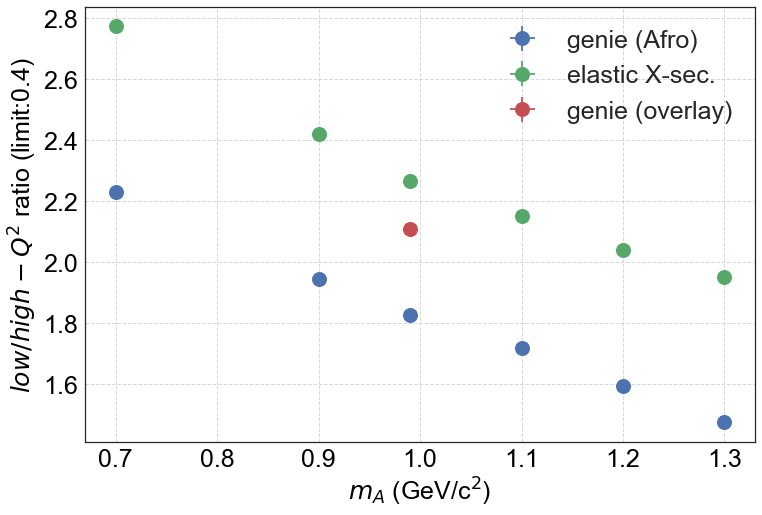

In [39]:
observable_low_high_ratio(var='Q2',var_name='Q^2',low_high_border=0.4,var_min=0.0,var_max=1.2)

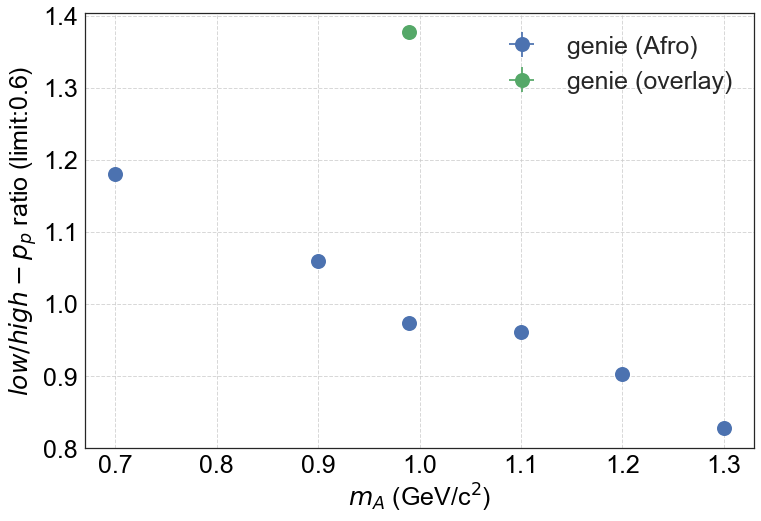

In [40]:
observable_low_high_ratio(var='Pp',var_name='p_p',low_high_border=0.6,do_add_elastic_Xsec=False,var_min=0.0,var_max=1.2)

# and how good is the $p_p$ reconsturction compared to $Q^2$ reconstruction?

In [12]:
MCbnbDATAcosmicPairsFV, MCbnbDATAcosmicSamples = load_MCbnbDATAcosmicSamples()
cuts_pureff = apply_cuts_MCbnbDATAcosmic(PIDa_p_min=12,                                                                             
                         delta_Delta_phi=40,                         
                         r_max_RdQ_CC1p0pi=0.33)
pureff_MCbnbDATAcosmic,pureff_MCbnbDATAcosmic_numbers = cuts_pureff
pureff_MCbnbDATAcosmic

50939 pairs from MC-BNB + cosmic DATA overlay
30377 pairs in FV
3814 are 1mu-1p, 12.6%
4001 are other pairs, 13.2%
22562 are cosmic, 74.3%
--------------------------------------------------------------
1234 are CC 1p 0pi, 4.1%


,$\mu p$ eff.,$\mu p$ pur.,CC$0\pi 1 p$ eff.,CC$0\pi 1 p$ pur.,label,1mu-1p,other pairs,cosmic,CC 1p 0pi
no cut,100.0%,12.6%,100.0%,4.1%,no cut,100.0% (3814),100.0% (4001),100.0% (22562),100.0% (1234)
non-collinearity first,90.4%,45.3%,94.8%,15.4%,"$|\theta_{1,2}-90^0|<60^0$",90.4% (3446),42.7% (1707),10.9% (2462),94.8% (1170)
PIDa,79.9%,45.6%,76.1%,14.0%,${PID}_a>12$,79.9% (3046),38.4% (1536),9.3% (2102),76.1% (939)
length,64.0%,59.4%,63.9%,19.2%,$l_{\mu}>l_{p}$,64.0% (2440),20.3% (812),3.8% (855),63.9% (789)
non-collinearity,58.5%,70.8%,61.4%,24.0%,"$|\theta_{1,2}-90^0|<60^0$",58.5% (2231),14.2% (570),1.6% (351),61.4% (758)
vertex activity,34.2%,78.3%,53.2%,39.4%,"$\sqrt{\sum_{p=0,1,2}(R_{\Delta Q}^{p}-1)^2}<0...",34.2% (1306),5.9% (235),0.6% (127),53.2% (657)
delta phi,24.1%,87.7%,47.9%,56.3%,$|\Delta \phi - \pi|<40^0$,24.1% (921),2.1% (85),0.2% (44),47.9% (591)
theta_pq,17.5%,95.4%,39.4%,69.4%,$\theta_{pq}<25^0$,17.5% (668),0.8% (32),0.0% (0),39.4% (486)
Pt no Delta phi,24.7%,88.7%,46.1%,53.6%,$p_{t}<0.35$ GeV/c,24.7% (941),2.5% (99),0.1% (21),46.1% (569)
soft Pt,20.2%,94.6%,42.9%,65.1%,$p_{t}<0.35$ GeV/c,20.2% (769),1.1% (43),0.0% (1),42.9% (529)


In [13]:
sns.set(style="white", color_codes=True ,font_scale=2);

In [15]:
sample = reduced_MCbnbDATAcosmicSamples['soft Pt']['CC 1p 0pi']

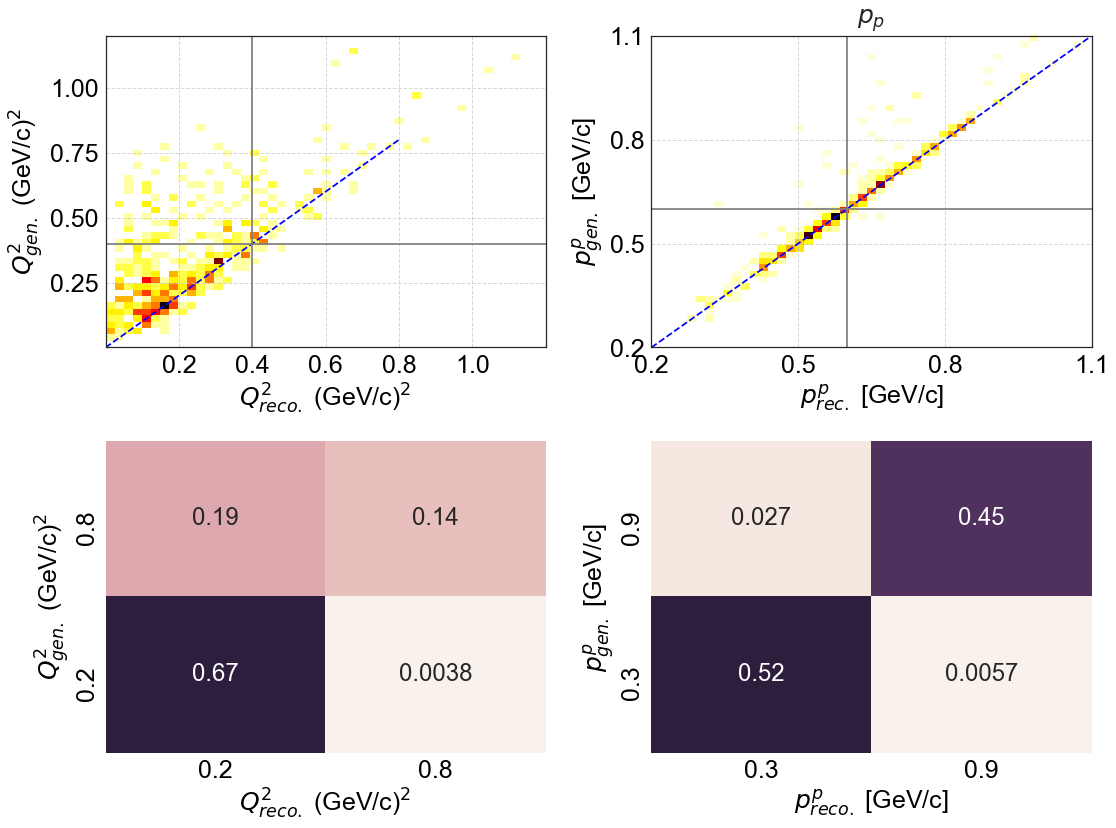

In [16]:
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(2,2,1)
ax.plot([0.0,0.8],[0.0,0.8],'--',color='blue',alpha=1)
plot_2d_hist(sample['reco_Q2'],sample['truth_Q2']
                 ,bins=(np.linspace(0,1.2,50),np.linspace(0,1.2,50)),ax=ax);
set_axes(ax,do_add_grid=True
                 ,x_label=Q2label('reco.'), xticks=[0.2,0.4,0.6,0.8,1.0]
                 ,y_label=Q2label('gen.'), yticks=[0.25,0.5,0.75,1]
                )
ax.plot([0.4,0.4],ax.get_ylim(),'-',color='grey',alpha=1)
ax.plot(ax.get_xlim(),[0.4,0.4],'-',color='grey',alpha=1)



ax = fig.add_subplot(2,2,2)
ax.plot([0.2,1.2],[0.2,1.2],'--',color='blue',alpha=1)
plot_2d_hist(sample['reco_Pp'],sample['truth_Pp'],bins=(np.linspace(0.2,1.1,50),np.linspace(0.2,1.1,50)),ax=ax);
set_axes(ax,do_add_grid=True,title=r'$p_p$'
                 ,x_label=r'$p^p_{rec.}$ [GeV/c]', xticks=np.linspace(0.2,1.1,4)
                 ,y_label=r'$p^p_{gen.}$ [GeV/c]', yticks=np.linspace(0.2,1.1,4)
                )        
ax.plot([0.6,0.6],ax.get_ylim(),'-',color='grey',alpha=1)
ax.plot(ax.get_xlim(),[0.6,0.6],'-',color='grey',alpha=1)


    
h = np.zeros((2,2))
h_total = 0
Q2min_bins = np.array([0.0,0.4])
Q2max_bins = np.array([0.4,1.2])                    
Q2_centers = 0.5*(Q2min_bins + Q2max_bins)
for i_Q2,(recQ2min,recQ2max) in enumerate(zip(Q2min_bins,Q2max_bins)):
    for j_Q2,(truthQ2min,truthQ2max) in enumerate(zip(Q2min_bins,Q2max_bins)):
        h[i_Q2][j_Q2] = len(sample[(sample['reco_Q2']>recQ2min)                                                  
                                          &(sample['reco_Q2']<recQ2max)                                          
                                          &(sample['truth_Q2']>truthQ2min)                                          
                                          &(sample['truth_Q2']<truthQ2max)])     
        h_total += h[i_Q2][j_Q2]
for i_Q2,(recQ2min,recQ2max) in enumerate(zip(Q2min_bins,Q2max_bins)):
    for j_Q2,(truthQ2min,truthQ2max) in enumerate(zip(Q2min_bins,Q2max_bins)):
         h[i_Q2][j_Q2] = float(h[i_Q2][j_Q2])/h_total
ax = fig.add_subplot(2,2,3)
sns.heatmap(h.T,annot=True,xticklabels=Q2_centers,yticklabels=Q2_centers,cbar=False);
set_axes(ax,do_add_grid=True
                 ,x_label=Q2label('reco.')
                 ,y_label=Q2label('gen.')
                )
ax.invert_yaxis()


h = np.zeros((2,2))
h_total = 0
Pp_min_bins = np.array([0.0,0.6])
Pp_max_bins = np.array([0.6,1.2])                    
Pp_centers = 0.5*(Pp_min_bins + Pp_max_bins)
for i_Pp,(recPpmin,recPpmax) in enumerate(zip(Pp_min_bins,Pp_max_bins)):
    for j_Pp,(truthPpmin,truthPpmax) in enumerate(zip(Pp_min_bins,Pp_max_bins)):
        h[i_Pp][j_Pp] = len(sample[(sample['reco_Pp']>recPpmin)                                                  
                                          &(sample['reco_Pp']<recPpmax)                                          
                                          &(sample['truth_Pp']>truthPpmin)                                          
                                          &(sample['truth_Pp']<truthPpmax)])     
        h_total += h[i_Pp][j_Pp]
for i_Pp,(recPpmin,recPpmax) in enumerate(zip(Pp_min_bins,Pp_max_bins)):
    for j_Pp,(truthPpmin,truthPpmax) in enumerate(zip(Pp_min_bins,Pp_max_bins)):
         h[i_Pp][j_Pp] = float(h[i_Pp][j_Pp])/h_total
ax = fig.add_subplot(2,2,4)
sns.heatmap(h.T,annot=True,xticklabels=Pp_centers,yticklabels=Pp_centers,cbar=False);
set_axes(ax,do_add_grid=True
                 ,x_label=r'$p^p_{reco.}$ [GeV/c]'
                 ,y_label=r'$p^p_{gen.}$ [GeV/c]'
                )
ax.invert_yaxis()

plt.tight_layout()

# what is the correlation between $Q^2$ and $p_p$?

In [32]:
sample = CC1p0pi['mA=%.2f'%0.99]

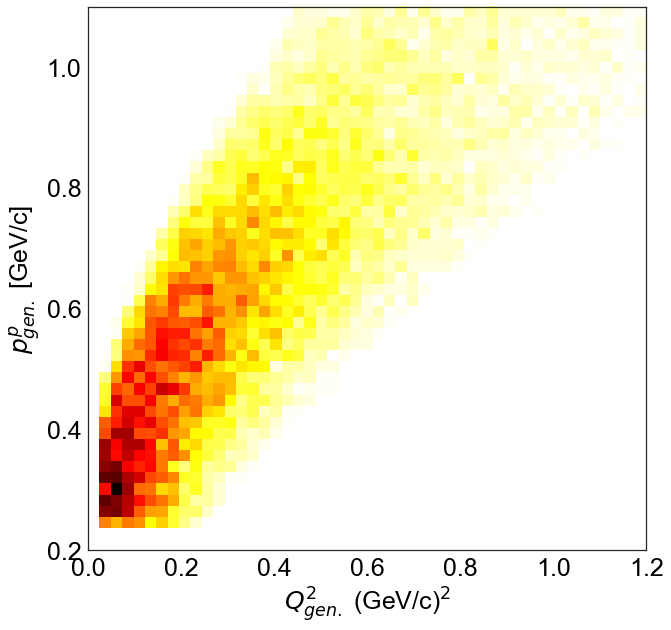

In [33]:
plot_2d_hist(sample['Q2'],sample['Pp'],xlabel=Q2label('gen.'),ylabel=r'$p^p_{gen.}$ [GeV/c]'
             ,bins=(np.linspace(0,1.2,50),np.linspace(0.2,1.1,50)));

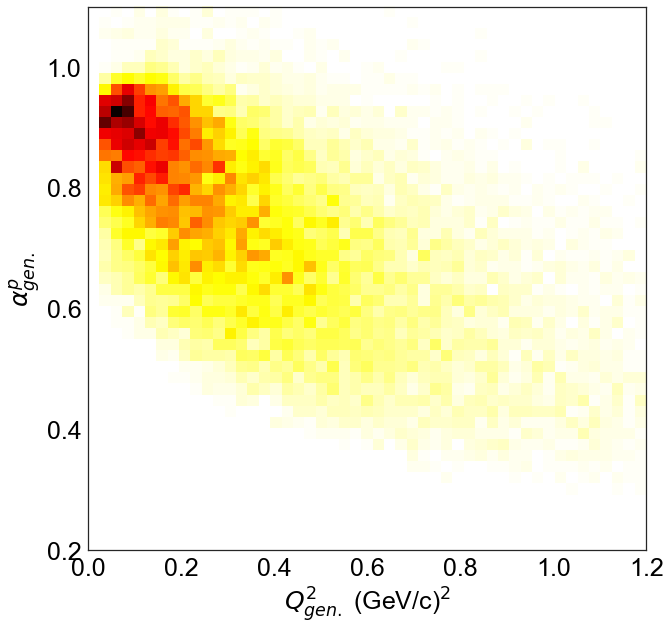

In [35]:
plot_2d_hist(sample['Q2'],sample['alpha_p'],xlabel=Q2label('gen.'),ylabel=r'$\alpha^p_{gen.}$'
             ,bins=(np.linspace(0,1.2,50),np.linspace(0.2,1.1,50)));

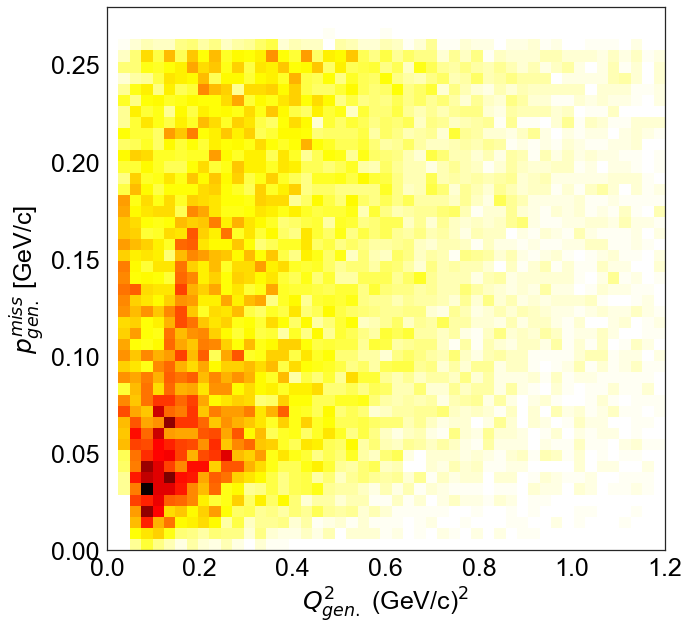

In [55]:
plot_2d_hist(sample['Q2'],sample['Pmiss'],xlabel=Q2label('gen.'),ylabel=r'$p^{miss}_{gen.}$ [GeV/c]'
             ,bins=(np.linspace(0,1.2,50),np.linspace(0.,0.28,50)));

In [49]:
genie_samples = dict()
CC1p0pi = dict()
for mA,name in zip([0.7,0.99,1.3]
                   ,['0_7','0_99','1_3']):
    genie_samples['mA=%.2f'%mA] = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/mA/genie_files/argon40_numu_mA_'+name+'.csv')
    CC1p0pi['mA=%.2f'%mA] = genie_samples['mA=%.2f'%mA][genie_samples['mA=%.2f'%mA]['CC1p0pi']==True]
    print 'len(CC1p0pi):',len(CC1p0pi['mA=%.2f'%mA])

len(CC1p0pi): 203
len(CC1p0pi): 21916
len(CC1p0pi): 268


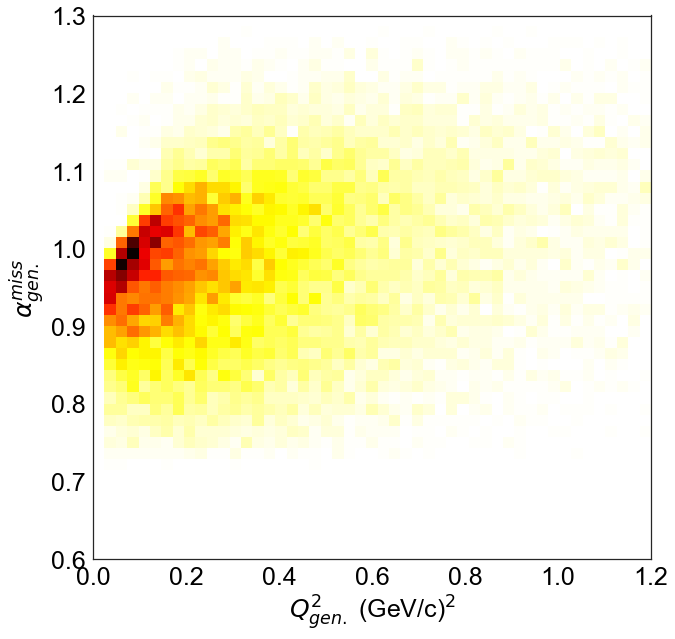

In [51]:
sample = CC1p0pi['mA=%.2f'%0.99]
plot_2d_hist(sample['Q2'],sample['alpha_miss'],xlabel=Q2label('gen.'),ylabel=r'$\alpha^{miss}_{gen.}$'
             ,bins=(np.linspace(0,1.2,50),np.linspace(0.6,1.3,50)));

# $\theta_p$ vs. $\theta_\mu$

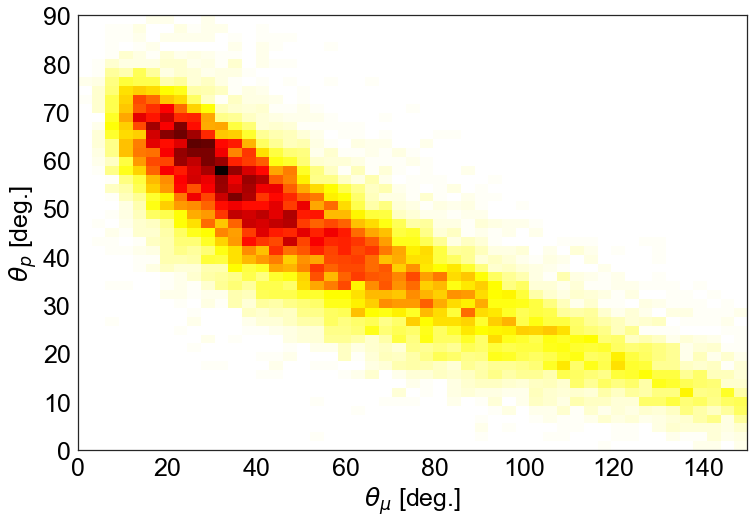

In [4]:
theta_mu = 180./np.pi*CC1p0pi['mA=%.2f'%0.99]['Pmu_theta']
theta_p = 180./np.pi*CC1p0pi['mA=%.2f'%0.99]['Pp_theta']
fig,ax=plt.subplots(figsize=(12,8))
plot_2d_hist( theta_mu , theta_p , bins=(np.linspace(0,150,50),np.linspace(0,90,50)),ax=ax);
set_axes(ax,r'$\theta_\mu$ [deg.]',r'$\theta_p$ [deg.]')

## weight each event by the elastic Cross-section for a given axial mass

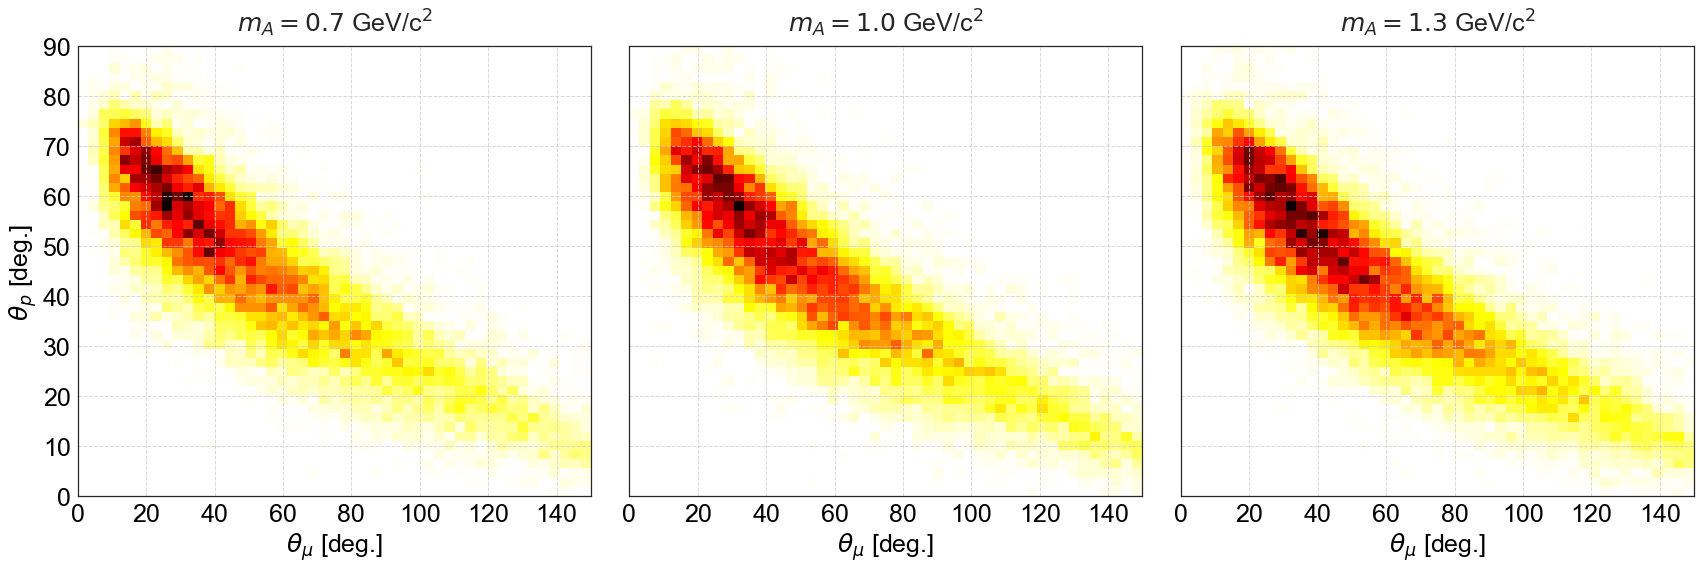

In [5]:
fig=plt.figure(figsize=(24,8))
for i_mA,mA in enumerate([0.7,0.99,1.3]):
    ax = fig.add_subplot(1,3,i_mA+1)
    sample = CC1p0pi['mA=%.2f'%mA]
    theta_mu = 180./np.pi*sample['Pmu_theta']
    theta_p = 180./np.pi*sample['Pp_theta']

    plot_2d_hist( theta_mu , theta_p , bins=(np.linspace(0,150,50),np.linspace(0,90,50)),ax=ax);
    set_axes(ax,r'$\theta_\mu$ [deg.]',r'$\theta_p$ [deg.]' if i_mA==0 else ''
             ,title=r'$m_A = %.1f$ GeV/c$^2$'%mA,do_add_grid=True)
    if i_mA>0: ax.yaxis.set_major_formatter(ticker.NullFormatter())
plt.tight_layout()    

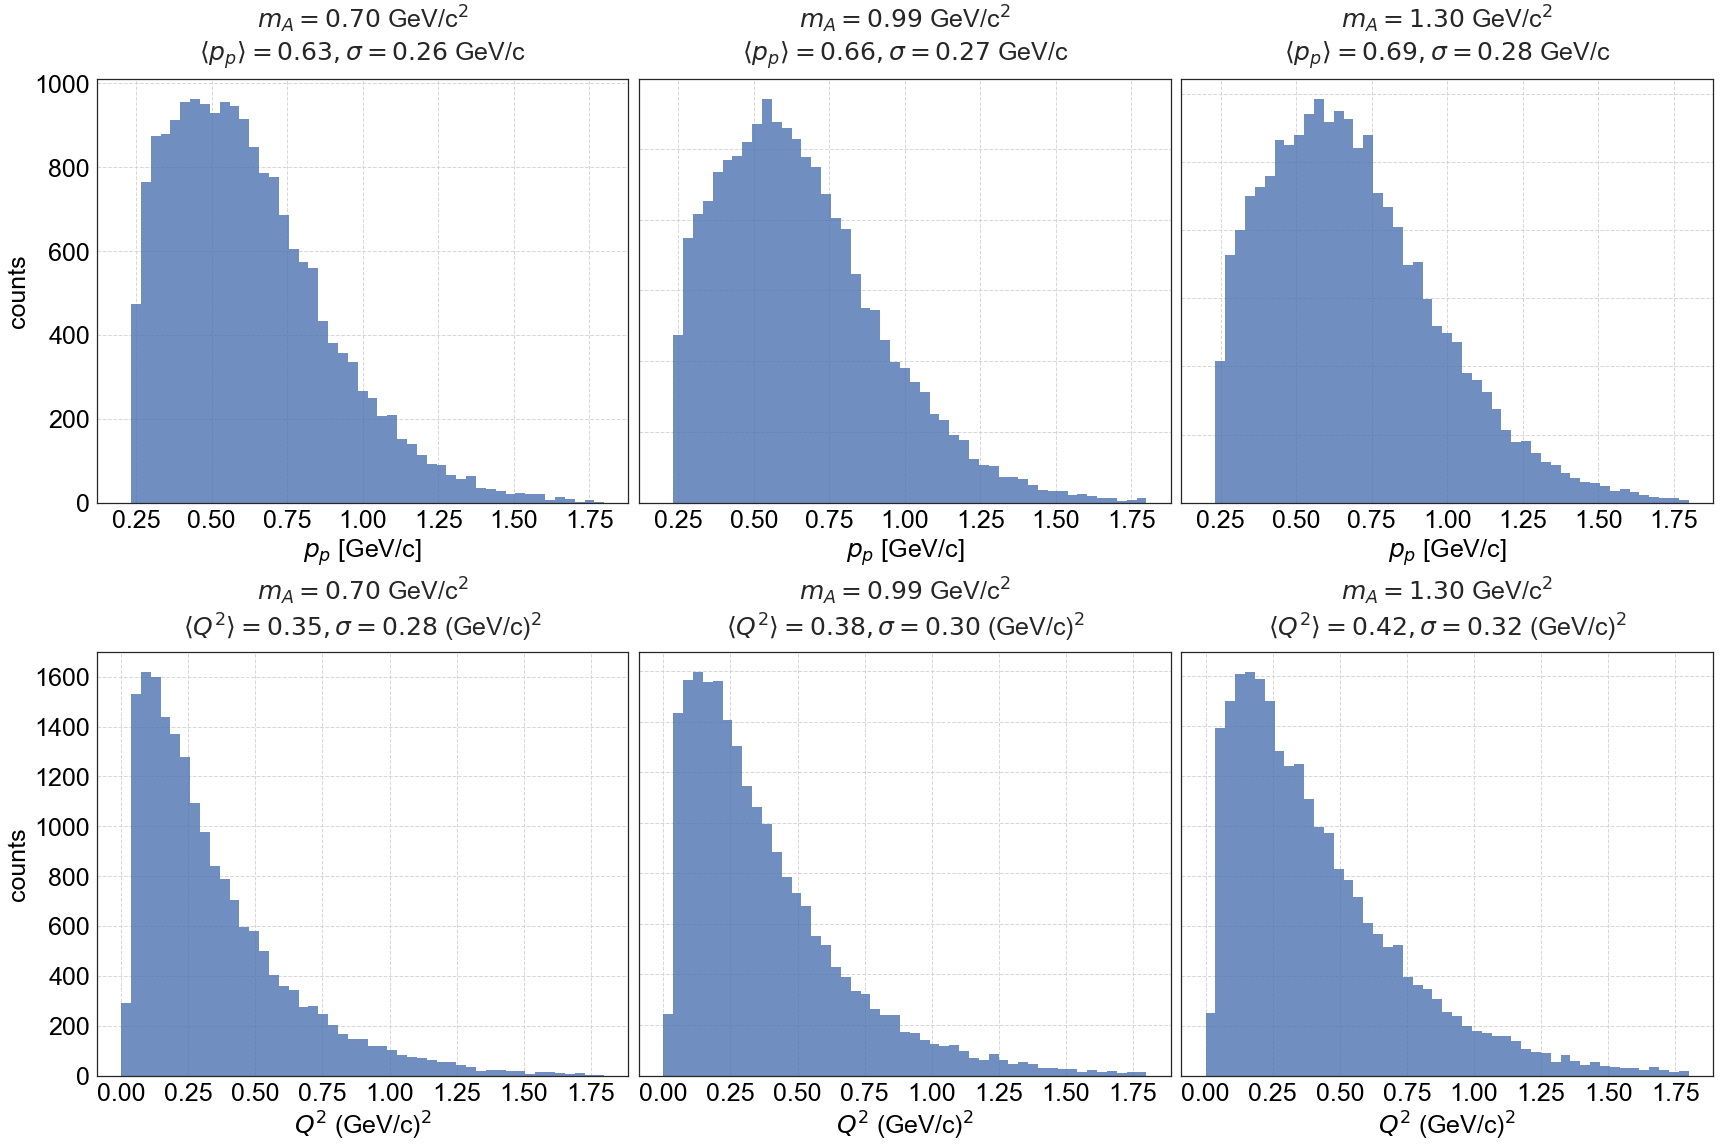

In [6]:
fig=plt.figure(figsize=(24,16))
for i_mA,mA in enumerate([0.7,0.99,1.3]):
    # Q2
    ax = fig.add_subplot(2,3,i_mA+1)
    sample = CC1p0pi['mA=%.2f'%mA]
    Pp = sample['Pp']
    h,bins,_=plt.hist( Pp , bins=np.linspace(0.2,1.8,50) , alpha=0.8)    
    t=0.5*(bins[1:]+bins[:-1]);dt=(t[1]-t[0])
    integral = np.sum([h[j]*dt for j in range(len(h))])
    mean = np.sum([h[j]*t[j]*dt for j in range(len(h))])/integral
    std = np.sqrt( (np.sum([h[j]*t[j]*t[j]*dt for j in range(len(h))])/integral) - np.square(mean) )


    set_axes(ax,r'$p_p$ [GeV/c]'
             ,'counts' if i_mA==0 else ''
             ,title=r'$m_A = %.2f$ GeV/c$^2$'%mA+'\n'+r'$\left<p_p\right>=%.2f, \sigma=%.2f$ GeV/c'%(mean,std)
             ,do_add_grid=True)
    if i_mA>0: ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ## Pp
    ax = fig.add_subplot(2,3,i_mA+1+3)
    sample = CC1p0pi['mA=%.2f'%mA]
    h,bins,_=plt.hist( sample['Q2'] , bins=np.linspace(0.0,1.8,50) , alpha=0.8)    
    t=0.5*(bins[1:]+bins[:-1]);dt=(t[1]-t[0])
    integral = np.sum([h[j]*dt for j in range(len(h))])
    mean = np.sum([h[j]*t[j]*dt for j in range(len(h))])/integral
    std = np.sqrt( (np.sum([h[j]*t[j]*t[j]*dt for j in range(len(h))])/integral) - np.square(mean) )

    set_axes(ax,Q2label()
             ,'counts' if i_mA==0 else ''
             ,title=r'$m_A = %.2f$ GeV/c$^2$'%mA+'\n'+r'$\left<Q^2\right>=%.2f, \sigma=%.2f$ (GeV/c)$^2$'%(mean,std)
             ,do_add_grid=True)
    if i_mA>0: ax.yaxis.set_major_formatter(ticker.NullFormatter())
plt.tight_layout()    

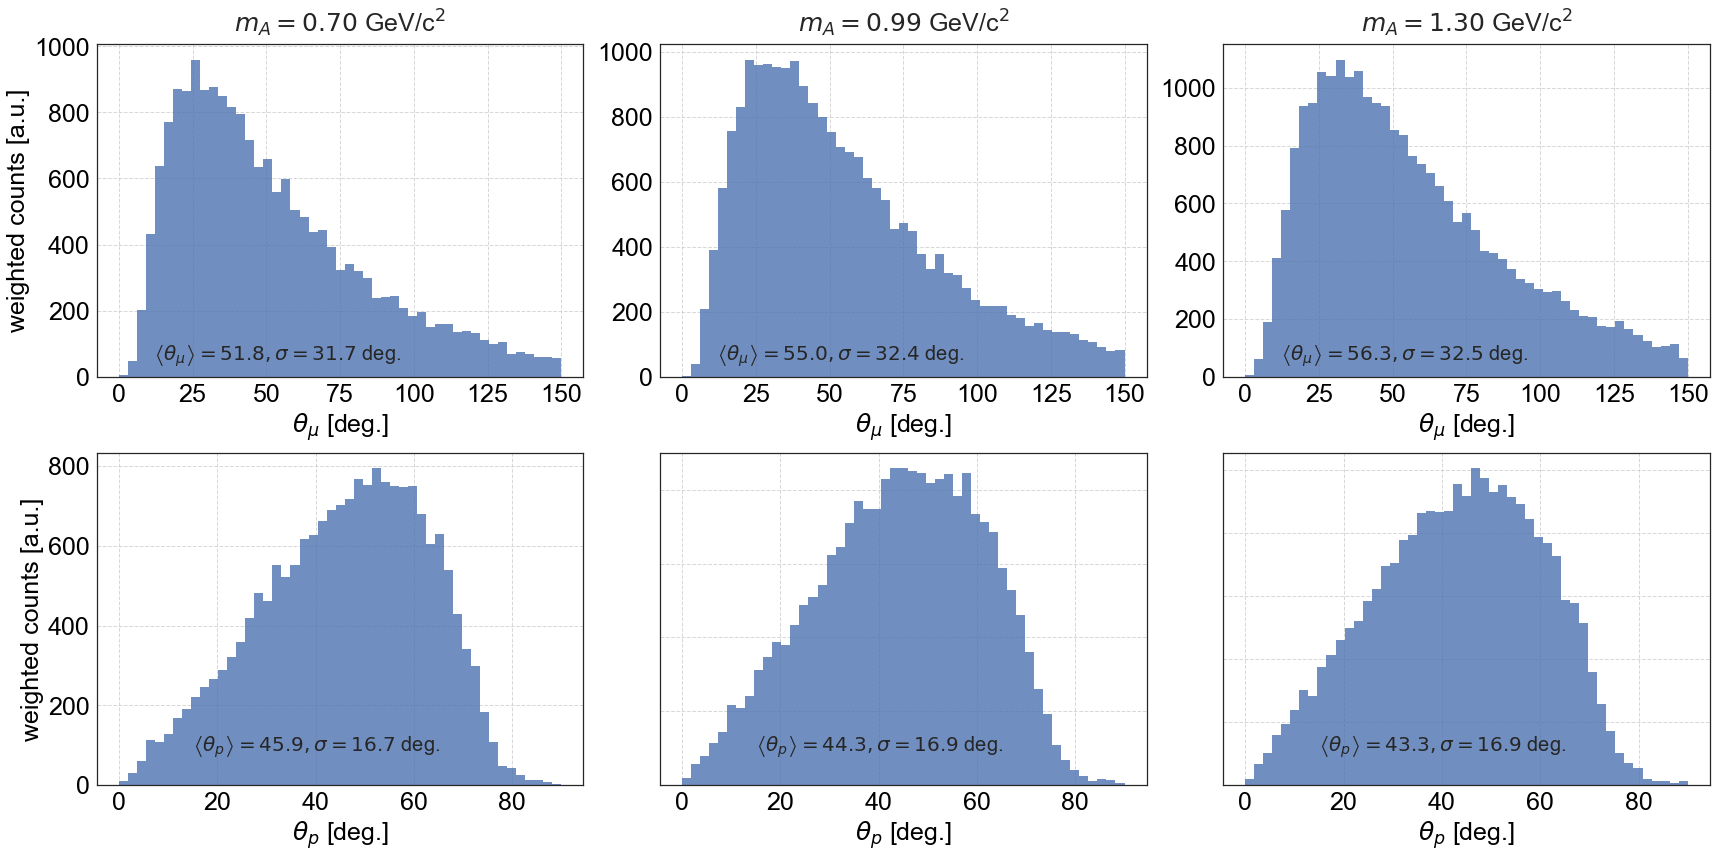

In [7]:
fig=plt.figure(figsize=(24,12))
for i_mA,mA in enumerate([0.7,0.99,1.3]):
    sample = CC1p0pi['mA=%.2f'%mA]
    theta_mu = 180./np.pi*sample['Pmu_theta']
    theta_p = 180./np.pi*sample['Pp_theta']

    ax = fig.add_subplot(2,3,i_mA+1)

    h,bins,_=plt.hist( theta_mu , bins=np.linspace(0,150,50) , alpha=0.8)    
    t=0.5*(bins[1:]+bins[:-1]);dt=(t[1]-t[0])
    integral = np.sum([h[j]*dt for j in range(len(h))])
    mean = np.sum([h[j]*t[j]*dt for j in range(len(h))])/integral
    std = np.sqrt( (np.sum([h[j]*t[j]*t[j]*dt for j in range(len(h))])/integral) - np.square(mean) )

    plt.text(12,0.05*np.max(ax.get_ylim()),r'$\left<\theta_\mu\right>=%.1f, \sigma=%.1f$ deg.'%(mean,std),fontsize=20)

    set_axes(ax,r'$\theta_\mu$ [deg.]'
             , r'weighted counts [a.u.]' if i_mA==0 else ''
             ,title=r'$m_A = %.2f$ GeV/c$^2$'%mA
             ,do_add_grid=True)
    
    ax = fig.add_subplot(2,3,i_mA+1+3)
    h,bins,_=plt.hist( theta_p , bins=np.linspace(0,90,50) , alpha=0.8)    
    t=0.5*(bins[1:]+bins[:-1]);dt=(t[1]-t[0])
    integral = np.sum([h[j]*dt for j in range(len(h))])
    mean = np.sum([h[j]*t[j]*dt for j in range(len(h))])/integral
    std = np.sqrt( (np.sum([h[j]*t[j]*t[j]*dt for j in range(len(h))])/integral) - np.square(mean) )
    plt.text(15,0.1*np.max(ax.get_ylim()),r'$\left<\theta_p\right>=%.1f, \sigma=%.1f$ deg.'%(mean,std),fontsize=20)
    set_axes(ax,r'$\theta_p$ [deg.]' 
             , r'weighted counts [a.u.]' if i_mA==0 else ''
             ,do_add_grid=True)
    if i_mA>0: ax.yaxis.set_major_formatter(ticker.NullFormatter())
plt.tight_layout() 